直接学习游戏环境

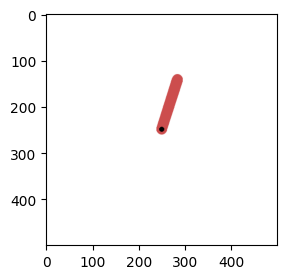

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(
            [action * 2])
        over = terminated or truncated

        #偏移reward,便于训练
        reward = (reward + 8) / 8

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch


class FakeEnv(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.s = torch.nn.Sequential(
            torch.nn.Linear(4, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
        )

        self.next_state = torch.nn.Linear(64, 3)
        self.reward = torch.nn.Sequential(
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )

    def forward(self, state, action):
        state = self.s(torch.cat([state, action], dim=1))
        return self.next_state(state) + state[:, :3], self.reward(state)


fake_env = FakeEnv()

fake_env(torch.randn(5, 3), torch.randn(5, 1))

(tensor([[ 0.0763,  0.0989, -0.1105],
         [ 0.0565,  0.0827, -0.1343],
         [ 0.0818,  0.1618, -0.1522],
         [ 0.1293,  0.1526, -0.1936],
         [ 0.1190,  0.1070, -0.1644]], grad_fn=<AddBackward0>),
 tensor([[-0.0517],
         [-0.0228],
         [-0.0824],
         [ 0.0954],
         [ 0.0202]], grad_fn=<TanhBackward0>))

In [3]:
import random


#环境学习阶段使用随机动作即可
def get_action(state):
    return random.normalvariate(mu=0, sigma=1)


get_action(None)

0.8862467149389309

In [4]:
from IPython import display


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = get_action(state)

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

-17.940597483586142

In [5]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]

    #获取一批数据样本
    def sample(self):
        data = random.sample(self.pool, 64)

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)
        action = torch.FloatTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 3)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return state, action, reward, next_state, over


pool = Pool()
pool.update()
pool.sample()

len(pool), pool[0]

/tmp/ipykernel_30896/741254263.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)


(200,
 (array([-0.9725334 ,  0.23276345,  0.6766915 ], dtype=float32),
  -1.0031992633485094,
  -0.06231842345025762,
  array([-0.97857887,  0.2058723 ,  0.55126405], dtype=float32),
  False))

In [6]:
#训练
def train(epochs, test_epoch):
    fake_env.train()
    optimizer = torch.optim.Adam(fake_env.parameters(), lr=1e-3)
    loss_fn = torch.nn.MSELoss()

    #共更新N轮数据
    for epoch in range(epochs):
        pool.update()

        #每次更新数据后,训练N次
        for i in range(200):

            #采样N条数据
            state, action, reward, next_state, over = pool.sample()

            #模型计算
            p_next_state, p_reward = fake_env(state, action)

            loss_next_state = loss_fn(p_next_state, next_state)
            loss_reward = loss_fn(p_reward, reward)
            (loss_next_state + loss_reward).backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % test_epoch == 0:
            print(epoch, len(pool), loss_next_state.item(), loss_reward.item(),
                  play()[-1])


#环境学习阶段
train(200, 20)

0 400 0.002726170001551509 0.0034544081427156925 10.500285682848135
20 4400 0.0005868636653758585 0.00016088939446490258 75.48046000174062
40 8400 0.00025014541461132467 0.00010767048661364242 40.06568712378257
60 12400 0.0006259015644900501 0.00010308342461939901 65.8760412209607
80 16400 9.059047442860901e-05 5.647194120683707e-05 92.80258071329621
100 20000 0.00010283117444487289 8.087384048849344e-05 31.64233141467606
120 20000 0.0002828323340509087 6.70949521008879e-05 45.58520385601917
140 20000 0.00020551285706460476 5.288568354444578e-05 82.84478483553508
160 20000 0.0002938929828815162 0.00010266354365739971 65.76003958624305
180 20000 7.851848931750283e-05 4.320243533584289e-05 56.1610114488039


In [7]:
#使用虚拟环境获取最优动作
def get_action(state):
    #初始化N步动作的分布
    mu = torch.zeros(1, 15)
    sigma = torch.ones(1, 15)

    state = torch.FloatTensor(state).reshape(1, -1).repeat(50, 1)
    state_clone = state.clone()

    #反复优化N次动作的分布
    for _ in range(5):
        #根据N步动作的分布抽样生成N份动作链
        action = mu + torch.randn(50, 15) * sigma
        reward_sum = torch.zeros(50, 1)
        state = state_clone

        #按顺序执行N步的动作,计算Q
        for i in range(15):
            state, reward = fake_env(state, action[:, i].unsqueeze(dim=1))
            reward_sum += reward * 0.95**i

        #求分数最高的N份动作链
        sort = reward_sum.flatten().sort(descending=True).indices
        action = action[sort][:10]

        #修正动作链的分布
        mu = 0.5 * mu + 0.5 * action.mean(dim=0, keepdim=True)
        sigma = 0.5 * sigma + 0.5 * action.std(dim=0, keepdim=True)

    #返回最优动作
    return mu[0, 0].item()


get_action(torch.randn(1, 3))

-1.2537051439285278

In [8]:
#动作学习阶段
train(10, 1)

0 20000 4.735264883493073e-05 6.272528116824105e-05 184.5788197796783
1 20000 0.0001188941314467229 4.5524706365540624e-05 183.58295882971538
2 20000 0.00011217351857339963 2.686530933715403e-05 168.53254854354407
3 20000 5.298547330312431e-05 4.754511974169873e-05 184.28078113247653
4 20000 7.20681346138008e-05 2.5564015231793746e-05 152.4564468631718
5 20000 0.0002979194978252053 0.00015095982234925032 168.47206662447832
6 20000 0.00015631772112101316 0.0002335681492695585 183.68430699254807
7 20000 0.00020789820700883865 3.983889109804295e-05 183.3188395321095
8 20000 7.334992551477626e-05 4.645865556085482e-05 159.81474878790993
9 20000 4.5181670429883525e-05 2.8182716050650924e-05 169.60035595148403


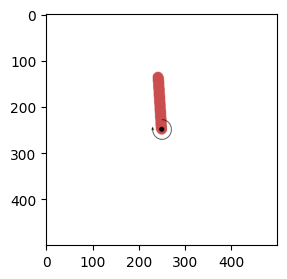

183.52116816080024

In [9]:
play(True)[-1]